## Python Notebook to study the use of xarray for data handling

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
import pandas as pd

import scipy.interpolate as interp
%matplotlib inline

In [184]:
# Colormap selection
xr.set_options(cmap_divergent='bwr', cmap_sequential='turbo')

In [238]:
dataDIR = 'data/OMI_trno2_0.10x0.10_201904_Col3_V4.nc'
mfdataDIR = 'data/2019/3B-MO.MS.MRG.3IMERG.*.V06B.HDF5.SUB.nc4'
mfdataDIR2 = 'data/2009/3B-MO.MS.MRG.3IMERG.*.V06B.HDF5.SUB.nc4'

ds1 = xr.open_dataset(dataDIR)
ds2 = xr.open_mfdataset(mfdataDIR, parallel=True)
ds3 = xr.open_mfdataset(mfdataDIR2, parallel=True)

### Dealing with datasets of type 1 i.e. ds1

In [4]:
ds1

<xarray.Dataset>
Dimensions:          (nLat: 1800, nLon: 3600)
Dimensions without coordinates: nLat, nLon
Data variables:
    LatitudeCenter   (nLat) float32 ...
    LongitudeCenter  (nLon) float32 ...
    TroposphericNO2  (nLat, nLon) float32 ...
Attributes:
    Title:        OMI NO2
    Author:       Lok Lamsal (lok.lamsal@nasa.gov)
    Institution:  NASA GSFC
    History:      Created: 09/01/2020

In [9]:
no2 = ds1["TroposphericNO2"]
lat = ds1["LatitudeCenter"]
lon = ds1["LongitudeCenter"]

ds = xr.Dataset(
    {
        "no2": (["lat","lon"],no2),
    },
    coords = {
        "lon": ("lon", lon),
        "lat": ("lat", lat),
    },
)

ds

<xarray.Dataset>
Dimensions:  (lat: 1800, lon: 3600)
Coordinates:
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 179.9
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    no2      (lat, lon) float32 -1.268e+30 -1.268e+30 ... -1.268e+30 -1.268e+30

In [10]:
ds1_ind = ds.sel(lat=slice(5,40), lon=slice(50,100)).dropna("lat")
ds1_ind

<xarray.Dataset>
Dimensions:  (lat: 350, lon: 500)
Coordinates:
  * lon      (lon) float32 50.05 50.15 50.25 50.35 ... 99.65 99.75 99.85 99.95
  * lat      (lat) float32 5.05 5.15 5.25 5.35 5.45 ... 39.65 39.75 39.85 39.95
Data variables:
    no2      (lat, lon) float32 1e+14 1.527e+14 ... 8.449e+14 8.829e+14

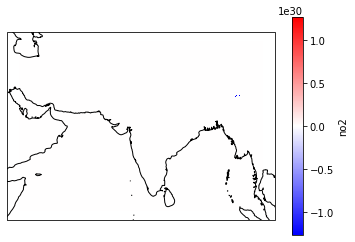

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
ax.coastlines()

ds1_ind.no2.plot()

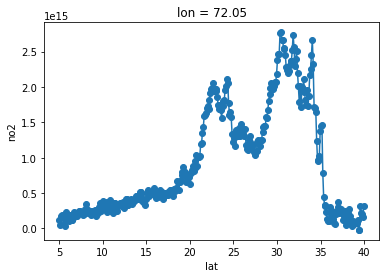

In [12]:
ds1_ind.no2.isel(lon=220).plot(marker="o")

### Dealing with datasets of type 2 i.e. ds2

In [186]:
ds2

<xarray.Dataset>
Dimensions:        (lat: 1800, lon: 3600, time: 12)
Coordinates:
  * time           (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
  * lon            (lon) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * lat            (lat) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
Data variables:
    precipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
Attributes:
    CDI:                                    Climate Data Interface version 1....
    Conventions:                            CF-1.6
    Original_Producer_Metadata_FileHeader:  DOI=10.5067/GPM/IMERG/3B-MONTH/06...
    Original_Producer_Metadata_FileInfo:    DataFormatVersion=6a;\nTKCodeBuil...
    Original_Producer_Metadata_GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegis...
    InputPointer:                           3B-MO.MS.MRG.3IMERG.20190101-S000...
    history_L34RS:                          'Created by L34RS v1.4.2 @ NASA G...
    CDO:                                    Climate Data Operators version 1....

In [187]:
# Transpose the data to get lat first and lon after - 

ds2 = ds2.transpose("time", "lat", "lon")

In [188]:
# make preciptation rate to preciptation

def convert_to_precipitaion(ds):
    temp = ds * 24
#     temp = temp.to_dataset()
    return temp

ds2 = convert_to_precipitaion(ds2)

In [189]:
# selecting the monsoon season data for the Indian Region
ds2_ind = ds2.sel(time=slice("2019-05-01", "2019-07-01"), lat=slice(5,40), lon=slice(50,100)).dropna("time")
ds2_ind

<xarray.Dataset>
Dimensions:        (lat: 350, lon: 500, time: 3)
Coordinates:
  * time           (time) datetime64[ns] 2019-05-01 2019-06-01 2019-07-01
  * lon            (lon) float32 50.05 50.15 50.25 50.35 ... 99.75 99.85 99.95
  * lat            (lat) float32 5.05 5.15 5.25 5.35 ... 39.65 39.75 39.85 39.95
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 350, 500), meta=np.ndarray>
Attributes:
    CDI:                                    Climate Data Interface version 1....
    Conventions:                            CF-1.6
    Original_Producer_Metadata_FileHeader:  DOI=10.5067/GPM/IMERG/3B-MONTH/06...
    Original_Producer_Metadata_FileInfo:    DataFormatVersion=6a;\nTKCodeBuil...
    Original_Producer_Metadata_GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegis...
    InputPointer:                           3B-MO.MS.MRG.3IMERG.20190101-S000...
    history_L34RS:                          'Created by L34RS v1.4.2 @ NASA G...
    CDO:                                    Climate Data Operators version 1....

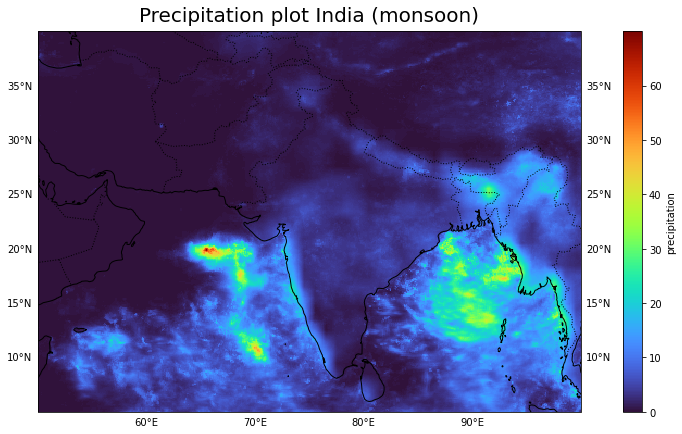

In [190]:
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
# ax.coastlines()

# ds2_ind.precipitation.isel(time=1).plot()

fig = plt.figure(figsize=(15, 7))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([50, 100, 5, 40], crs=ccrs.PlateCarree())
ds2_ind.precipitation.isel(time=1).plot()
gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gridliner.top_labels = False
gridliner.bottom_labels = True
gridliner.left_labels = True
gridliner.right_labe = False
gridliner.ylines = False  # you need False
gridliner.xlines = False  # you need False

# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
ax.set_title("Precipitation plot India (monsoon)", pad=10, fontsize=20)

# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES.with_scale('10m')) # To add states other than that of USA we have scale 10m
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)

In [191]:
# Same plots but with interpolation
### Uncomment the lines below #####

# fig, axes = plt.subplots(ncols=2, figsize=(15, 7))

# ds2_ind.precipitation.isel(time=1).plot(ax = axes[0])
# axes[0].set_title("Raw data")

# # Interpolated data
# new_lon = np.linspace(ds2_ind.lon[0], ds2_ind.lon[-1], ds2_ind.dims["lon"] * 4)
# new_lat = np.linspace(ds2_ind.lat[0], ds2_ind.lat[-1], ds2_ind.dims["lat"] * 4)
# dsi = ds2_ind.interp(lat=new_lat, lon=new_lon)

# dsi.precipitation.isel(time=1).plot(ax=axes[1])
# axes[1].set_title("Interpolated data")

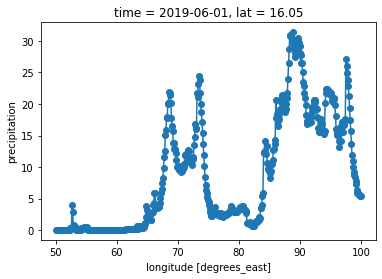

In [192]:
ds2_ind.precipitation.isel(time=1, lat=110).plot(marker="o")

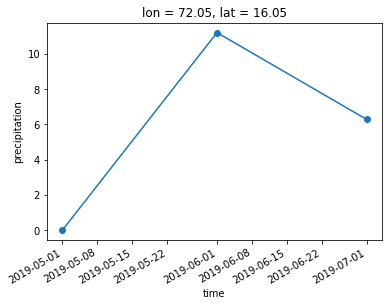

In [193]:
ds2_ind.precipitation.isel(lon=220, lat=110).plot(marker="o")

### Calculating seasonal averages

In [194]:
# Data containing all months

ds2_ind_all = ds2.sel(lat=slice(5,40), lon=slice(50,100)).dropna("time")

ds2_ind_all

<xarray.Dataset>
Dimensions:        (lat: 350, lon: 500, time: 12)
Coordinates:
  * time           (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
  * lon            (lon) float32 50.05 50.15 50.25 50.35 ... 99.75 99.85 99.95
  * lat            (lat) float32 5.05 5.15 5.25 5.35 ... 39.65 39.75 39.85 39.95
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 350, 500), meta=np.ndarray>
Attributes:
    CDI:                                    Climate Data Interface version 1....
    Conventions:                            CF-1.6
    Original_Producer_Metadata_FileHeader:  DOI=10.5067/GPM/IMERG/3B-MONTH/06...
    Original_Producer_Metadata_FileInfo:    DataFormatVersion=6a;\nTKCodeBuil...
    Original_Producer_Metadata_GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegis...
    InputPointer:                           3B-MO.MS.MRG.3IMERG.20190101-S000...
    history_L34RS:                          'Created by L34RS v1.4.2 @ NASA G...
    CDO:                                    Climate Data Operators version 1....

In [195]:
# Calculating the weighted average as each month has different number of days

month_length = ds2_ind_all.time.dt.days_in_month
month_length

<xarray.DataArray 'days_in_month' (time: 12)>
array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01

In [196]:
# Calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (ds2_ind_all * weights).groupby('time.season').sum(dim='time')

In [197]:
ds_weighted

<xarray.Dataset>
Dimensions:        (lat: 350, lon: 500, season: 4)
Coordinates:
  * lon            (lon) float32 50.05 50.15 50.25 50.35 ... 99.75 99.85 99.95
  * lat            (lat) float32 5.05 5.15 5.25 5.35 ... 39.65 39.75 39.85 39.95
  * season         (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    precipitation  (season, lat, lon) float64 dask.array<chunksize=(1, 350, 500), meta=np.ndarray>

In [198]:
ds_unweighted = ds2_ind_all.groupby('time.season').mean('time')
ds_diff = ds_weighted - ds_unweighted

Text(0.5, 1.02, 'Precipitation')

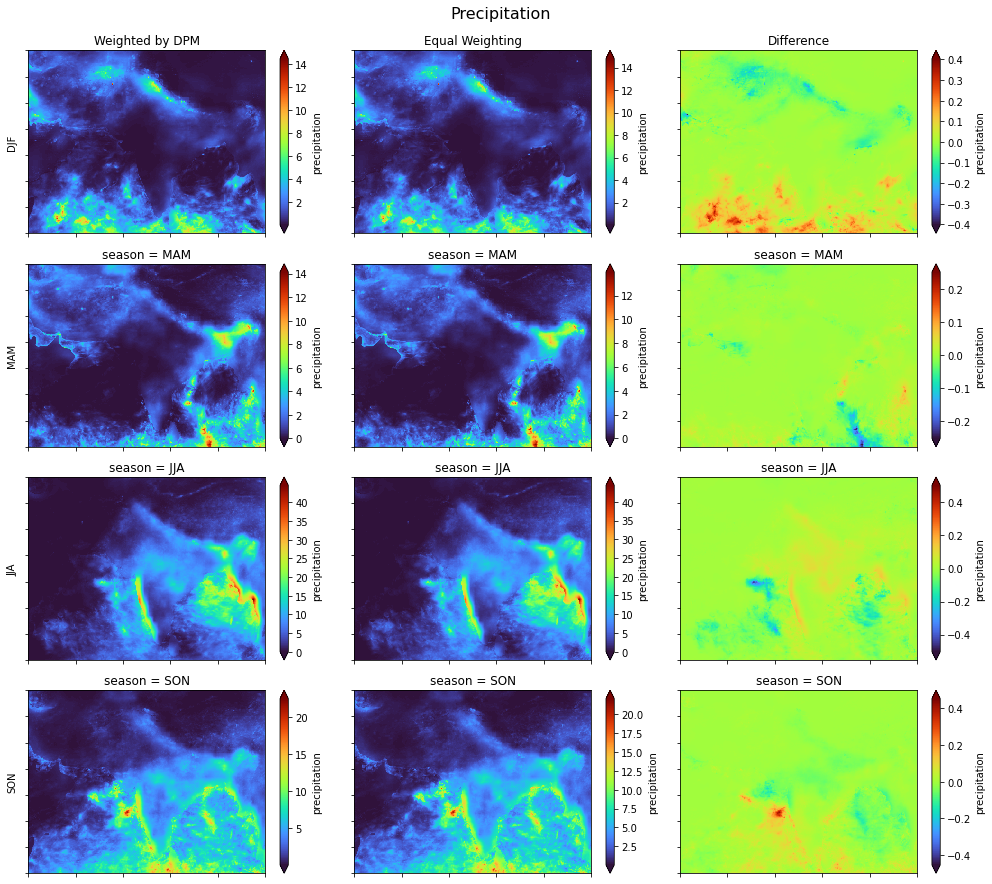

In [199]:
# Quick plot to show the results
notnull = pd.notnull(ds_unweighted['precipitation'][0])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    ds_weighted['precipitation'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 0], cmap='turbo',
        add_colorbar=True, extend='both')

    ds_unweighted['precipitation'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 1], cmap='turbo',
        add_colorbar=True, extend='both')

    ds_diff['precipitation'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 2],cmap='turbo',
        add_colorbar=True, extend='both')

    axes[i, 0].set_ylabel(season)
    axes[i, 1].set_ylabel('')
    axes[i, 2].set_ylabel('')

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')

axes[0, 0].set_title('Weighted by DPM')
axes[0, 1].set_title('Equal Weighting')
axes[0, 2].set_title('Difference')

plt.tight_layout()

fig.suptitle('Precipitation', fontsize=16, y=1.02)

#### Here is the main function

In [200]:
# Wrap it into a simple function
def season_mean(ds, calendar='standard'):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

In [201]:
ds2ind_seasonal_mean = season_mean(ds2_ind_all)

# and for the world

ds2_seasonal_mean = season_mean(ds2)

In [202]:
ds2ind_seasonal_mean

<xarray.Dataset>
Dimensions:        (lat: 350, lon: 500, season: 4)
Coordinates:
  * lon            (lon) float32 50.05 50.15 50.25 50.35 ... 99.75 99.85 99.95
  * lat            (lat) float32 5.05 5.15 5.25 5.35 ... 39.65 39.75 39.85 39.95
  * season         (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    precipitation  (season, lat, lon) float64 dask.array<chunksize=(1, 350, 500), meta=np.ndarray>

In [203]:
ds2_seasonal_mean

<xarray.Dataset>
Dimensions:        (lat: 1800, lon: 3600, season: 4)
Coordinates:
  * lon            (lon) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * lat            (lat) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * season         (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    precipitation  (season, lat, lon) float64 dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>

### Plotting the various seaonal averages

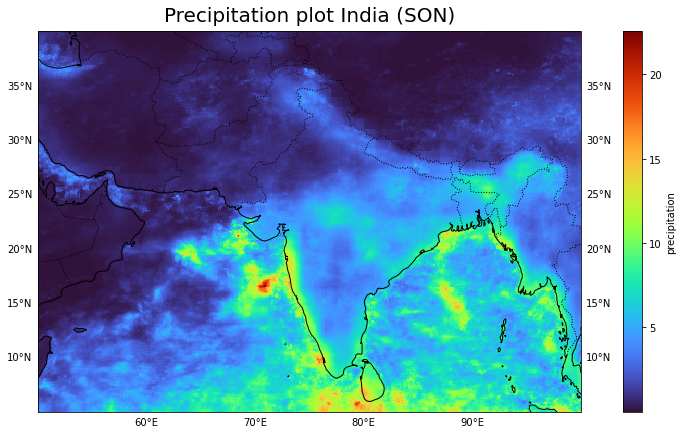

In [207]:
# Pre-monsoon

fig = plt.figure(figsize=(15, 7))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([50, 100, 5, 40], crs=ccrs.PlateCarree())
ds2ind_seasonal_mean.precipitation.isel(season = 3).plot()  # Change this value in bracket to get different season
gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gridliner.top_labels = False
gridliner.bottom_labels = True
gridliner.left_labels = True
gridliner.right_labe = False
gridliner.ylines = False  # you need False
gridliner.xlines = False  # you need False

# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
ax.set_title("Precipitation plot India (SON)", pad=10, fontsize=20) # change the label as well

# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES.with_scale('10m')) # To add states other than that of USA we have scale 10m
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)

### Grouping as pre-monsoon, monsoon and post-monsoon instead

In [234]:
# def is_jjas(month):
#     return (month >= 6) & (month <= 9)

# seasonal_temp = temp.sel(time=is_jjas(temp['time.month']))

# # wrapping in a function
def get_season_mean(ds, season_name, calendar='standard'):
    
    """
    Enter input xarray dataset and enter the seaon_name as premon, mon or postmon
    """
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    temp = (ds * weights).groupby('time.month').sum(dim='time')
#     return (ds * weights).groupby('time.month').sum(dim='time')

    if season_name == "premon":
        start_index = temp["month"][1]
        end_index = temp["month"][4]
        temp2 =  temp.sel(month=slice(start_index, end_index))
    elif season_name == "mon":
        start_index = temp["month"][5]
        end_index = temp["month"][8]
        temp2 = temp.sel(month=slice(start_index, end_index))
    else:
        temp2 =  temp.sel(month=[9, 10, 11, 1])
        
    return temp2.mean(dim='month')

In [235]:
ds2ind_seasonal_mean2 = get_season_mean(ds2_ind_all, "mon")
ds2ind_seasonal_mean2

<xarray.Dataset>
Dimensions:        (lat: 350, lon: 500)
Coordinates:
  * lon            (lon) float32 50.05 50.15 50.25 50.35 ... 99.75 99.85 99.95
  * lat            (lat) float32 5.05 5.15 5.25 5.35 ... 39.65 39.75 39.85 39.95
Data variables:
    precipitation  (lat, lon) float64 dask.array<chunksize=(350, 500), meta=np.ndarray>

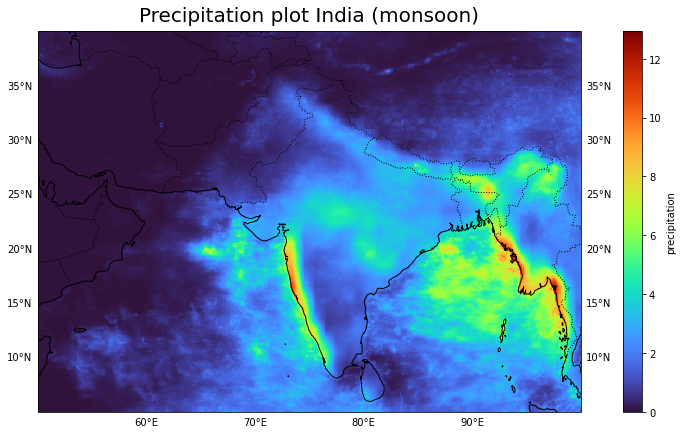

In [236]:
# Making the plot

fig = plt.figure(figsize=(15, 7))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([50, 100, 5, 40], crs=ccrs.PlateCarree())
ds2ind_seasonal_mean2.precipitation.plot()
gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gridliner.top_labels = False
gridliner.bottom_labels = True
gridliner.left_labels = True
gridliner.right_labe = False
gridliner.ylines = False  # you need False
gridliner.xlines = False  # you need False

# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
ax.set_title("Precipitation plot India (monsoon)", pad=10, fontsize=20) # change the label for the three seasons

# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES.with_scale('10m')) # To add states other than that of USA we have scale 10m
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)

### Now with data set 3 or 2009 Monsoon

In [239]:
ds3

<xarray.Dataset>
Dimensions:        (lat: 1800, lon: 3600, time: 12)
Coordinates:
  * time           (time) datetime64[ns] 2009-01-01 2009-02-01 ... 2009-12-01
  * lon            (lon) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * lat            (lat) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
Data variables:
    precipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
Attributes:
    CDI:                                    Climate Data Interface version 1....
    Conventions:                            CF-1.6
    Original_Producer_Metadata_FileHeader:  DOI=10.5067/GPM/IMERG/3B-MONTH/06...
    Original_Producer_Metadata_FileInfo:    DataFormatVersion=6a;\nTKCodeBuil...
    Original_Producer_Metadata_GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegis...
    InputPointer:                           3B-MO.MS.MRG.3IMERG.20090101-S000...
    history_L34RS:                          'Created by L34RS v1.4.2 @ NASA G...
    CDO:                                    Climate Data Operators version 1....

In [240]:
# Transpose the data to get lat first and lon after - 

ds3 = ds3.transpose("time", "lat", "lon")

In [241]:
# make preciptation rate to preciptation

def convert_to_precipitaion(ds):
    temp = ds * 24
#     temp = temp.to_dataset()
    return temp

ds3 = convert_to_precipitaion(ds3)

In [242]:
# selecting the monsoon season data for the Indian Region
ds3_ind_all = ds3.sel(lat=slice(5,40), lon=slice(50,100)).dropna("time")
ds3_ind_all

<xarray.Dataset>
Dimensions:        (lat: 350, lon: 500, time: 12)
Coordinates:
  * time           (time) datetime64[ns] 2009-01-01 2009-02-01 ... 2009-12-01
  * lon            (lon) float32 50.05 50.15 50.25 50.35 ... 99.75 99.85 99.95
  * lat            (lat) float32 5.05 5.15 5.25 5.35 ... 39.65 39.75 39.85 39.95
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 350, 500), meta=np.ndarray>
Attributes:
    CDI:                                    Climate Data Interface version 1....
    Conventions:                            CF-1.6
    Original_Producer_Metadata_FileHeader:  DOI=10.5067/GPM/IMERG/3B-MONTH/06...
    Original_Producer_Metadata_FileInfo:    DataFormatVersion=6a;\nTKCodeBuil...
    Original_Producer_Metadata_GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegis...
    InputPointer:                           3B-MO.MS.MRG.3IMERG.20090101-S000...
    history_L34RS:                          'Created by L34RS v1.4.2 @ NASA G...
    CDO:                                    Climate Data Operators version 1....

### Calculating seasonal averages

In [243]:
ds3ind_seasonal_mean = season_mean(ds3_ind_all)

# and for the world

ds3_seasonal_mean = season_mean(ds3)

In [245]:
ds3ind_seasonal_mean

<xarray.Dataset>
Dimensions:        (lat: 350, lon: 500, season: 4)
Coordinates:
  * lon            (lon) float32 50.05 50.15 50.25 50.35 ... 99.75 99.85 99.95
  * lat            (lat) float32 5.05 5.15 5.25 5.35 ... 39.65 39.75 39.85 39.95
  * season         (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    precipitation  (season, lat, lon) float64 dask.array<chunksize=(1, 350, 500), meta=np.ndarray>

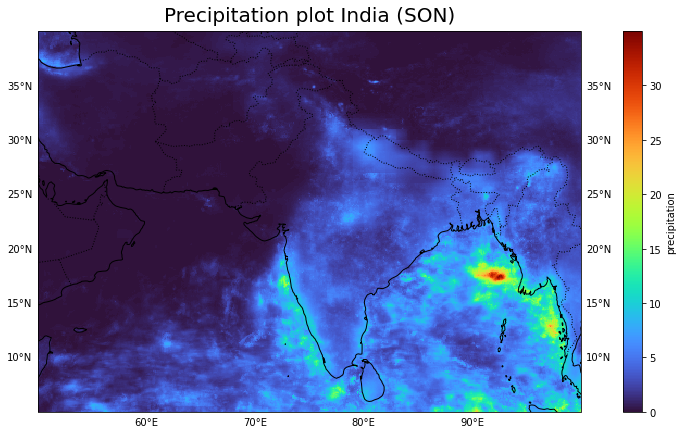

In [244]:
# Pre-monsoon

fig = plt.figure(figsize=(15, 7))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([50, 100, 5, 40], crs=ccrs.PlateCarree())
ds3ind_seasonal_mean.precipitation.isel(season = 3).plot()  # Change this value in bracket to get different season
gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gridliner.top_labels = False
gridliner.bottom_labels = True
gridliner.left_labels = True
gridliner.right_labe = False
gridliner.ylines = False  # you need False
gridliner.xlines = False  # you need False

# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
ax.set_title("Precipitation plot India (SON)", pad=10, fontsize=20) # change the label as well

# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES.with_scale('10m')) # To add states other than that of USA we have scale 10m
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)

### Grouping as pre-monsoon, monsoon and post-monsoon instead

In [249]:
ds3ind_seasonal_mean2 = get_season_mean(ds3_ind_all, "premon")
ds3ind_seasonal_mean2

<xarray.Dataset>
Dimensions:        (lat: 350, lon: 500)
Coordinates:
  * lon            (lon) float32 50.05 50.15 50.25 50.35 ... 99.75 99.85 99.95
  * lat            (lat) float32 5.05 5.15 5.25 5.35 ... 39.65 39.75 39.85 39.95
Data variables:
    precipitation  (lat, lon) float64 dask.array<chunksize=(350, 500), meta=np.ndarray>

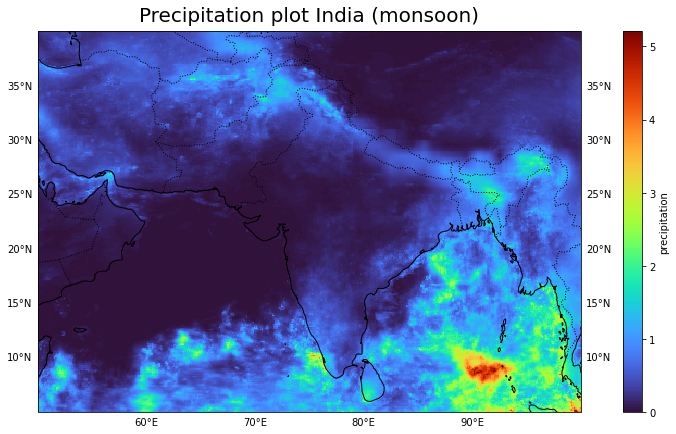

In [250]:
# Making the plot

fig = plt.figure(figsize=(15, 7))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([50, 100, 5, 40], crs=ccrs.PlateCarree())
ds3ind_seasonal_mean2.precipitation.plot()
gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gridliner.top_labels = False
gridliner.bottom_labels = True
gridliner.left_labels = True
gridliner.right_labe = False
gridliner.ylines = False  # you need False
gridliner.xlines = False  # you need False

# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
ax.set_title("Precipitation plot India (monsoon)", pad=10, fontsize=20) # change the label for the three seasons

# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES.with_scale('10m')) # To add states other than that of USA we have scale 10m
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)